In [1]:
# OpenCV Library for image processing 
import cv2 as cv
# NumPy library to do numerical operations such as calculating bounding box and other required calculations 
import numpy as np
# Connection to Operating system
import os
# For plotting graphs
import matplotlib.pyplot as plt
# For TensorFlow library to do machine learning task
import tensorflow as tf

# For Machine Learning tasks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# For building CNN 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization, Activation


# For plotting confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# VGG16 pre-trained model for transfer learning 
from keras.applications import VGG16

# For data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For reducing learning rate - callback used to train model 
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [2]:
# Function that loads the images from the set folder and then stores the UNO card color with the images
def load_images_from_folder(folder_path):
    # Initialize variable for images and labels 
    images = []
    labels = []
    # Access files in the folder path set 
    for filename in os.listdir(folder_path):
        # If the file is in .png format 
        if filename.endswith('.png'):
            # Stores image path as combination of folder path and the file name 
            image_path = os.path.join(folder_path, filename)
            # Stores image from file 
            img = cv.imread(image_path)
            # Converts it to RGB format 
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            # Adds it to the list that stores all the images 
            images.append(img)
            # Extracts the color label by taking first element before the hyphen 
            label = filename.split('-')[0]
            # Adds it to the list of labels
            labels.append(label)
            # Prints message of images and labels stored
            print(f"Loaded image: {filename}, Label: {label}")
    # Prints total amount of images and labels 
    print(f"Total images loaded: {len(images)}, Total labels loaded: {len(labels)}")
    return images, labels

In [3]:
# Function for finding and extracting ROI 
def find_roi_for_images(images):
    # To store extracted ROI 
    rois = []
    # Loops through all the images 
    for img in images:
        # Starts from first converting to grayscale using cvtColor
        gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        
        # Gaussian blur for reducing noise and lead to better result for finding ROI 
        # (5,5) is the kernel size set to determine how string blurring will be done 
        # 0 is for standard deviation which is set to default and calculated by OpenCV 
        blurred = cv.GaussianBlur(gray, (5, 5), 0)
        
        # Adaptive thresholding to catch edges
        # 255 means pixel intensity value which is set to max intensity 
        # ADAPTIVE_THRESH_GAUSSIAN_C does calculation for weighted sum of neighborhood value while THRESH_BINARY_INV sets values accordingly to threshold value so that it is set to either 0 or 255 
        thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)        
        
        # Find contours - external ones (RETR_EXTERNAL) and edges of shape (CHAIN_APPROX_SIMPLE)
        contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        
        # Applies If loop is contour is true and found 
        if contours:
            # Finds and store contour with largest area 
            max_contour = max(contours, key=cv.contourArea)
            
            # Setting up size of bounding box
            # Sets minimum area fro rectangle
            rect = cv.minAreaRect(max_contour)
            # Stores the 4 points of box
            box = cv.boxPoints(rect)
            # Convert those point to numerical integers 
            box = np.intp(box)
            
            # Calculates width and height of bounding box 
            width = int(np.linalg.norm(box[0] - box[1]))
            height = int(np.linalg.norm(box[1] - box[2]))
            
            # Calculates whether bounding box should be portrait or landscape sizing 
            # If width is smaller than height - then portrait 
            if width < height:
                # Sets the bounding box points to be portrait 
                new_points = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
            # If width is bigger than height - then landscape 
            else:
                # Sets the bounding box points to be landscape 
                new_points = np.float32([[0, 0], [height, 0], [height, width], [0, width]])

            # Calculates the perspective transformation matrix to map points from one perspective
            # Used when dealing with images from different camera angles 
            M = cv.getPerspectiveTransform(np.float32(box), new_points)
            
            # Apply perspective transformation on image 
            roi = cv.warpPerspective(img, M, (width, height))
            
            # Resize ROI to standard image size 
            roi = cv.resize(roi, (128, 128))
            # Learning point: Face issue with of different image sizing causing errors so fixed sizing in function 
            
            # Add image to list 
            rois.append(roi)
        # If no contours found 
        else:
            # Print error message for it 
            print("No contours found for the current image")
    # Returns ROI 
    return np.array(rois)

In [4]:
# transfer learning model
def transfer_learning_model(input_shape, num_classes):
    # Load VGG16 per-trained model with ImageNet dataset
    # Model will not include top output layer from per-trained mode (include_top=False) but rather take our code ones  
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Loops through the layers in model 
    for layer in base_model.layers:
        # Stops them from training to freeze them 
        layer.trainable = False
    # Flatten layer - convert to 1D feature vector to prepare for dense layer 
    x = Flatten()(base_model.output)
    #  Dense layer - to combine features extracted with relu to handle complex patterns 
    x = Dense(512, activation='relu')(x)
    # Output layer - final dense layer to connect features and give prediction with softmax to calculate probabilities
    output = Dense(num_classes, activation='softmax')(x)
    # Final model with pre-trained VGG16 model and above layers added 
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [5]:
# Sets path to find image data set 
folder_path = "C:\\Users\\bhati\\Python Code\\IS-CW2\\images"
# Applies function to get labels  
images, labels = load_images_from_folder(folder_path)

Loaded image: blue-0.png, Label: blue
Loaded image: blue-1.png, Label: blue
Loaded image: blue-2.png, Label: blue
Loaded image: blue-3.png, Label: blue
Loaded image: blue-4.png, Label: blue
Loaded image: blue-5.png, Label: blue
Loaded image: blue-6.png, Label: blue
Loaded image: blue-7.png, Label: blue
Loaded image: blue-8.png, Label: blue
Loaded image: blue-9.png, Label: blue
Loaded image: green-0.png, Label: green
Loaded image: green-1.png, Label: green
Loaded image: green-2.png, Label: green
Loaded image: green-3.png, Label: green
Loaded image: green-4.png, Label: green
Loaded image: green-5.png, Label: green
Loaded image: green-6.png, Label: green
Loaded image: green-7.png, Label: green
Loaded image: green-8.png, Label: green
Loaded image: green-9.png, Label: green
Loaded image: red-0.png, Label: red
Loaded image: red-1.png, Label: red
Loaded image: red-2.png, Label: red
Loaded image: red-3.png, Label: red
Loaded image: red-4.png, Label: red
Loaded image: red-5.png, Label: red
Load

In [6]:
# Collect unique labels from above 
unique_labels = np.unique(labels)
# Create dictionary which each label is mapped with number 
label_to_number = {label: i for i, label in enumerate(unique_labels)}
# Converts label to numerical value mapped above 
numeric_labels = np.array([label_to_number[label] for label in labels])


In [7]:
# Applies function to find ROI
images_roi = find_roi_for_images(images)

In [8]:
# Sets size to number of unique labels 
num_classes = len(unique_labels)

In [9]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Randomly rotate image plus or minus 20 degrees 
    rotation_range=20,
    # Randomly shift image horizontally 
    width_shift_range=0.2,
    # Randomly shift image vertically  
    height_shift_range=0.2,
    # Randomly zoom image 
    zoom_range=0.2,
    # Randomly horizontally flip images 
    horizontal_flip=True,
    # Fill new pixels created with nearest neighbour 
    fill_mode='nearest',
    # Randomly shift shear angle
    shear_range=0.2,
    # Randomly change brightness values 
    brightness_range=[0.8, 1.2],
    # Randomly shift RGB color values plus or minus 30 
    channel_shift_range=30
)

In [10]:
# Encodes the value by applying one-hot format
one_hot_labels = tf.keras.utils.to_categorical(numeric_labels, num_classes=num_classes)

# Reshape ROI to standard size 
images_array = np.array(images_roi).reshape((-1, 128, 128, 3))

In [11]:
# Function to split data into training and validation dataset 
def split_data(images, labels, test_size=0.3, random_state=42):
    # Calculates minimum length of images and labels 
    min_samples = min(len(images), len(labels))
    # Splits the data based on min_samples set above
    X_train, X_val, y_train, y_val = train_test_split(images[:min_samples], labels[:min_samples], test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

In [12]:
# Applies above function to split dataset 
X_train, X_val, y_train, y_val = split_data(images_array, one_hot_labels, test_size=0.3, random_state=42)

In [13]:
# Applies data augmentation set above on training data 
data_generator.fit(X_train)

# Sets callback to reduce learning if validation loss gets worse or stays the same for 5 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Create model by applying transfer_learning_model function 
model = transfer_learning_model((128, 128, 3), num_classes)
# Compile the mode with Adam optimizer to adjust learning rate while training to optimize performance of accuracy 
# categorical_crossentropy calculates the error in prediction 
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set the batch size 
batch_size = 32
# Calculates steps per epoch based on batch size 
steps_per_epoch = max(len(X_train) // batch_size, 1)  # Ensure steps_per_epoch is at least 1

# Train the model 
history = model.fit(
    # Apply data augmentation
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    # Set validation data set 
    validation_data=(X_val, y_val),
    # Set steps per epoch calculated above 
    steps_per_epoch=steps_per_epoch,
    # Set number of time model will run on training data set 
    epochs=80,
    # Set the reduce learning rate callback 
    callbacks=[reduce_lr],
    # Display progress bar during training 
    verbose=1
)

Epoch 1/80



1/1 [==============================] - 2s 2s/step - loss: 14.6988 - accuracy: 0.3214 - val_loss: 53.6977 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 2/80
1/1 [==============================] - 1s 782ms/step - loss: 47.4828 - accuracy: 0.6071 - val_loss: 88.8938 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/80
1/1 [==============================] - 1s 772ms/step - loss: 64.7383 - accuracy: 0.3929 - val_loss: 47.3000 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/80
1/1 [==============================] - 1s 779ms/step - loss: 37.8106 - accuracy: 0.7143 - val_loss: 32.9515 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/80
1/1 [==============================] - 1s 772ms/step - loss: 26.6637 - accuracy: 0.6786 - val_loss: 20.0611 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/80
1/1 [==============================] - 1s 787ms/step - loss: 11.9055 - accuracy: 0.6071 - val_loss: 7.0699 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/80
1/1 [==============================] - 1s 774ms/step - loss: 0.8264 - accu

1/1 [==============================] - 0s 335ms/step
Validation Accuracy: 1.0


<Figure size 800x800 with 0 Axes>

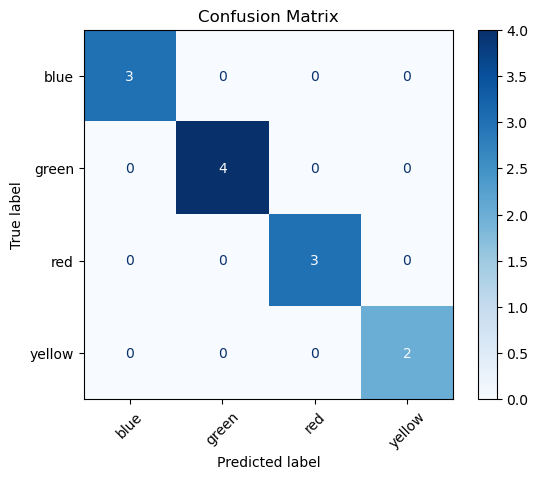

In [14]:
# Applies model to do prediction on validation 
y_pred = model.predict(X_val)
# Converts probability to the predicted class 
y_pred_classes = np.argmax(y_pred, axis=1)
# Converts probability to the predicted class 
y_val_classes = np.argmax(y_val, axis=1)
# Calculate accuracy score
val_accuracy = accuracy_score(y_val_classes, y_pred_classes)
# Display accuracy score
print(f"Validation Accuracy: {val_accuracy}")

# Generate confusion matrix for actual and true label 
cm = confusion_matrix(y_val_classes, y_pred_classes)
# Sets the parameter for confusion matrix plot 
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
# Set figure size 
plt.figure(figsize=(8,8))
# Plot confusion matrix
cm_display.plot(cmap=plt.cm.Blues)
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
# Set title 
plt.title('Confusion Matrix')
# Display plot 
plt.show()

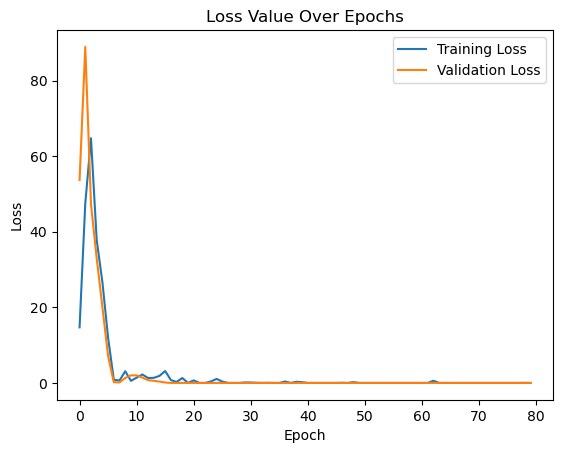

In [15]:
# Store the loss values for training and validation 
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss 
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Set labels for x and y axis 
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Set title for graph 
plt.title('Loss Value Over Epochs')
# Set legend for graph 
plt.legend()
# Display graph 
plt.show()

In [16]:
# Setting path to be in same folder and name of model 
model_save_path = 'uno_colorG_model.keras'
# Saving model to above setting 
model.save(model_save_path)
# Display message to user 
print(f"Model saved to {model_save_path}")

Model saved to uno_colorG_model.keras
